# 05 - Treinamento do Modelo SINKT

Este notebook implementa a **Etapa 5** do pipeline SINKT: treinamento do modelo Structure-aware INductive Knowledge Tracing.

## Objetivo
Treinar o modelo SINKT completo com:
- **TIEnc**: Textual Information Encoder (embeddings semânticos)
- **SIEnc**: Structural Information Encoder (GAT no grafo heterogêneo)
- **Student State Encoder**: GRU para dinâmica temporal
- **Response Predictor**: Predição de acerto/erro

## Entrada
- `data/output/notebooks/geracao_respostas_llm/interactions_complete.json`: Interações completas com respostas LLM
- `data/json/concepts_graph.json`: Grafo de conceitos
- `data/json/questions_graph.json`: Grafo de questões

## Saída
- Modelo treinado
- Métricas de desempenho (AUC, ACC, F1, Precision, Recall)

## Importação de Bibliotecas

In [1]:
!pip install numpy pandas jupyter ipython openai python-dotenv torch torch-geometric transformers scikit-learn matplotlib seaborn tqdm sentence-transformers

import json
import os
import numpy as np
import pandas as pd
from datetime import datetime
from typing import Dict, List, Tuple, Any
from collections import defaultdict
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.data import HeteroData

from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Configurações e Hiperparâmetros

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

config = {
    'text_embed_dim': 384,
    'hidden_dim': 128,
    'gat_heads': 4,
    'gat_layers': 2,
    'gru_layers': 2,
    'dropout': 0.3,
    'learning_rate': 0.001,
    'batch_size': 32,
    'num_epochs': 50,
    'early_stopping_patience': 10,
    'train_split': 0.7,
    'val_split': 0.15,
    'test_split': 0.15,
    'plm_model': 'sentence-transformers/all-MiniLM-L6-v2',
    'use_time_features': False
}

print("✅ Configurações definidas:")
for key, value in config.items():
    print(f"  - {key}: {value}")

✅ Configurações definidas:
  - text_embed_dim: 384
  - hidden_dim: 128
  - gat_heads: 4
  - gat_layers: 2
  - gru_layers: 2
  - dropout: 0.3
  - learning_rate: 0.001
  - batch_size: 32
  - num_epochs: 50
  - early_stopping_patience: 10
  - train_split: 0.7
  - val_split: 0.15
  - test_split: 0.15
  - plm_model: sentence-transformers/all-MiniLM-L6-v2
  - use_time_features: False


## Carregamento de Dados

In [3]:
with open('data/json/concepts_graph.json', 'r', encoding='utf-8') as f:
    concepts_data = json.load(f)
concepts = concepts_data['concepts']

with open('data/json/questions_graph.json', 'r', encoding='utf-8') as f:
    questions_data = json.load(f)
questions = questions_data['questions']

with open('data/output/notebooks/geracao_respostas_llm/interactions_complete.json', 'r', encoding='utf-8') as f:
    interactions_data = json.load(f)
interactions = interactions_data['interactions']

print(f"✅ Dados carregados:")
print(f"  - Conceitos: {len(concepts)}")
print(f"  - Questões: {len(questions)}")
print(f"  - Interações: {len(interactions)}")
print(f"  - Estudantes únicos: {len(set(i['student_id'] for i in interactions))}")

✅ Dados carregados:
  - Conceitos: 251
  - Questões: 680
  - Interações: 4499
  - Estudantes únicos: 100


## Preparação dos Dados

In [4]:
concept_id_to_idx = {c['id']: idx for idx, c in enumerate(concepts)}
question_id_to_idx = {q['id']: idx for idx, q in enumerate(questions)}

question_to_concepts = {}
for q_idx, q in enumerate(questions):
    c_id = q['c_id']
    if c_id in concept_id_to_idx:
        c_idx = concept_id_to_idx[c_id]
        question_to_concepts[q_idx] = [c_idx]

error_type_to_idx = {
    'slip': 0,
    'misconception': 1,
    'careless': 2,
    'incomplete': 3,
    'misunderstanding': 4,
    None: 5
}

question_type_to_idx = {
    'multiple_choice': 0,
    'descriptive': 1
}

student_sequences = defaultdict(list)
for interaction in interactions:
    student_id = interaction['student_id']
    q_id = interaction['question_id']
    is_correct = interaction['is_correct']
    error_type = interaction.get('error_type')
    question_type = interaction.get('question_type', 'multiple_choice')
    
    if q_id in question_id_to_idx:
        student_sequences[student_id].append({
            'question_idx': question_id_to_idx[q_id],
            'is_correct': int(is_correct),
            'timestamp': interaction['timestamp'],
            'error_type_idx': error_type_to_idx.get(error_type, 5),
            'question_type_idx': question_type_to_idx.get(question_type, 0)
        })

for student_id in student_sequences:
    student_sequences[student_id].sort(key=lambda x: x['timestamp'])

print(f"✅ Dados preparados:")
print(f"  - Conceitos indexados: {len(concept_id_to_idx)}")
print(f"  - Questões indexadas: {len(question_id_to_idx)}")
print(f"  - Estudantes com sequências: {len(student_sequences)}")
print(f"  - Média de interações por estudante: {np.mean([len(seq) for seq in student_sequences.values()]):.2f}")

✅ Dados preparados:
  - Conceitos indexados: 251
  - Questões indexadas: 680
  - Estudantes com sequências: 100
  - Média de interações por estudante: 44.99


## TIEnc: Textual Information Encoder

In [5]:
print("Carregando modelo de embeddings...")
embedding_model = SentenceTransformer(config['plm_model'])

concept_texts = []
for c in concepts:
    text = f"{c['nome']}: {c['definicao']}"
    concept_texts.append(text)

question_texts = []
for q in questions:
    text = f"{q['q']} {q.get('exp', '')}"
    question_texts.append(text)

print("Gerando embeddings de conceitos...")
concept_embeddings = embedding_model.encode(concept_texts, show_progress_bar=True, convert_to_numpy=True)

print("Gerando embeddings de questões...")
question_embeddings = embedding_model.encode(question_texts, show_progress_bar=True, convert_to_numpy=True)

concept_embeddings_tensor = torch.FloatTensor(concept_embeddings).to(device)
question_embeddings_tensor = torch.FloatTensor(question_embeddings).to(device)

print(f"\n✅ Embeddings gerados:")
print(f"  - Conceitos: {concept_embeddings_tensor.shape}")
print(f"  - Questões: {question_embeddings_tensor.shape}")

Carregando modelo de embeddings...
Gerando embeddings de conceitos...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Gerando embeddings de questões...


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


✅ Embeddings gerados:
  - Conceitos: torch.Size([251, 384])
  - Questões: torch.Size([680, 384])


## Construção do Grafo Heterogêneo

In [6]:
class StructuralInformationEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads=4, num_layers=2, dropout=0.3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.concept_proj = nn.Linear(input_dim, hidden_dim)
        self.question_proj = nn.Linear(input_dim, hidden_dim)
        
        self.c_to_c_convs = nn.ModuleList()
        self.c_to_q_convs = nn.ModuleList()
        self.q_to_c_convs = nn.ModuleList()
        
        for _ in range(num_layers):
            self.c_to_c_convs.append(GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout, add_self_loops=False))
            self.c_to_q_convs.append(GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout, add_self_loops=False))
            self.q_to_c_convs.append(GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout, add_self_loops=False))
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, graph_data):
        x_c = self.concept_proj(graph_data['concept'].x)
        x_q = self.question_proj(graph_data['question'].x)
        
        x_c_original = x_c.clone()
        x_q_original = x_q.clone()
        
        for layer in range(self.num_layers):
            x_c_new = x_c.clone()
            x_q_new = x_q.clone()
            
            if ('concept', 'prerequisite', 'concept') in graph_data.edge_types:
                edge_index_c_c = graph_data['concept', 'prerequisite', 'concept'].edge_index
                if edge_index_c_c.size(1) > 0:
                    x_c_from_c = self.c_to_c_convs[layer](x_c, edge_index_c_c)
                    x_c_new = x_c_new + x_c_from_c
            
            if ('concept', 'has_question', 'question') in graph_data.edge_types:
                edge_index_c_q = graph_data['concept', 'has_question', 'question'].edge_index
                if edge_index_c_q.size(1) > 0:
                    x_q_from_c = self.c_to_q_convs[layer]((x_c, x_q), edge_index_c_q)
                    x_q_new = x_q_new + x_q_from_c
            
            if ('question', 'relates_to', 'concept') in graph_data.edge_types:
                edge_index_q_c = graph_data['question', 'relates_to', 'concept'].edge_index
                if edge_index_q_c.size(1) > 0:
                    x_c_from_q = self.q_to_c_convs[layer]((x_q, x_c), edge_index_q_c)
                    x_c_new = x_c_new + x_c_from_q
            
            x_c = F.relu(x_c_new)
            x_q = F.relu(x_q_new)
            x_c = self.dropout(x_c)
            x_q = self.dropout(x_q)
        
        x_c = x_c + x_c_original
        x_q = x_q + x_q_original
        
        return x_c, x_q

print("✅ StructuralInformationEncoder definido")

✅ StructuralInformationEncoder definido


In [7]:
graph_data = HeteroData()

graph_data['concept'].x = concept_embeddings_tensor
graph_data['question'].x = question_embeddings_tensor

q_to_c_edges = []
c_to_q_edges = []

for q_idx, q in enumerate(questions):
    c_id = q['c_id']
    if c_id in concept_id_to_idx:
        c_idx = concept_id_to_idx[c_id]
        q_to_c_edges.append([q_idx, c_idx])
        c_to_q_edges.append([c_idx, q_idx])

if q_to_c_edges:
    graph_data['question', 'relates_to', 'concept'].edge_index = torch.LongTensor(q_to_c_edges).t().contiguous().to(device)
    graph_data['concept', 'has_question', 'question'].edge_index = torch.LongTensor(c_to_q_edges).t().contiguous().to(device)

c_to_c_edges = []
if 'relations' in concepts_data:
    for rel in concepts_data['relations']:
        source_id = rel.get('source_id')
        target_id = rel.get('target_id')
        if source_id in concept_id_to_idx and target_id in concept_id_to_idx:
            source_idx = concept_id_to_idx[source_id]
            target_idx = concept_id_to_idx[target_id]
            c_to_c_edges.append([source_idx, target_idx])

if c_to_c_edges:
    graph_data['concept', 'prerequisite', 'concept'].edge_index = torch.LongTensor(c_to_c_edges).t().contiguous().to(device)

print(f"✅ Grafo heterogêneo construído:")
print(f"  - Nós de conceitos: {graph_data['concept'].x.shape[0]}")
print(f"  - Nós de questões: {graph_data['question'].x.shape[0]}")
print(f"  - Arestas question->concept: {len(q_to_c_edges)}")
print(f"  - Arestas concept->question: {len(c_to_q_edges)}")
print(f"  - Arestas concept->concept: {len(c_to_c_edges)}")

✅ Grafo heterogêneo construído:
  - Nós de conceitos: 251
  - Nós de questões: 680
  - Arestas question->concept: 680
  - Arestas concept->question: 680
  - Arestas concept->concept: 322


In [8]:
class StudentStateEncoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, dropout=0.3, use_time_features=False):
        super().__init__()
        self.use_time_features = use_time_features
        
        input_size = hidden_dim * 2
        
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, concept_vecs_seq, responses_seq, time_features_seq=None):
        batch_size, seq_len, hidden_dim = concept_vecs_seq.shape
        
        v_seq = []
        for t in range(seq_len):
            u_t = concept_vecs_seq[:, t, :]
            r_t = responses_seq[:, t].unsqueeze(1)
            
            correct_part = u_t * r_t
            incorrect_part = u_t * (1 - r_t)
            
            v_t = torch.cat([correct_part, incorrect_part], dim=1)
            
            v_seq.append(v_t)
        
        v_seq = torch.stack(v_seq, dim=1)
        
        h_seq, _ = self.gru(v_seq)
        h_seq = self.dropout(h_seq)
        
        return h_seq

class ResponsePredictor(nn.Module):
    def __init__(self, hidden_dim, dropout=0.3):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, h_t, q_next, u_next):
        combined = torch.cat([h_t, q_next, u_next], dim=1)
        pred = self.fc(combined)
        return pred.squeeze(-1)

print("✅ StudentStateEncoder e ResponsePredictor definidos")

✅ StudentStateEncoder e ResponsePredictor definidos


In [9]:
class SINKT(nn.Module):
    def __init__(self, config, graph_data, question_to_concepts):
        super().__init__()
        self.config = config
        self.graph_data = graph_data
        self.question_to_concepts = question_to_concepts
        
        self.sienc = StructuralInformationEncoder(
            input_dim=config['text_embed_dim'],
            hidden_dim=config['hidden_dim'],
            num_heads=config['gat_heads'],
            num_layers=config['gat_layers'],
            dropout=config['dropout']
        )
        
        self.student_encoder = StudentStateEncoder(
            hidden_dim=config['hidden_dim'],
            num_layers=config['gru_layers'],
            dropout=config['dropout'],
            use_time_features=config.get('use_time_features', False)
        )
        
        self.response_predictor = ResponsePredictor(
            hidden_dim=config['hidden_dim'],
            dropout=config['dropout']
        )
        
    def forward(self, question_seq, response_seq, time_seq=None):
        concept_embeds, question_embeds = self.sienc(self.graph_data)
        
        batch_size, seq_len = question_seq.shape
        device = question_seq.device
        
        concept_vecs_seq = []
        for t in range(seq_len):
            q_indices = question_seq[:, t]
            
            batch_concept_vecs = []
            for b in range(batch_size):
                q_idx = q_indices[b].item()
                
                if q_idx in self.question_to_concepts and len(self.question_to_concepts[q_idx]) > 0:
                    c_indices = self.question_to_concepts[q_idx]
                    c_indices_tensor = torch.tensor(c_indices, dtype=torch.long, device=device)
                    c_vecs = concept_embeds[c_indices_tensor]
                    u_t = c_vecs.mean(dim=0)
                else:
                    u_t = torch.zeros(self.config['hidden_dim'], device=device)
                batch_concept_vecs.append(u_t)
            
            concept_vecs_seq.append(torch.stack(batch_concept_vecs))
        
        concept_vecs_seq = torch.stack(concept_vecs_seq, dim=1)
        
        h_seq = self.student_encoder(concept_vecs_seq, response_seq.float(), time_seq)
        
        predictions = []
        for t in range(seq_len - 1):
            h_t = h_seq[:, t, :]
            
            q_next_indices = question_seq[:, t + 1]
            q_next_vecs = question_embeds[q_next_indices]
            
            u_next_vecs = concept_vecs_seq[:, t + 1, :]
            
            pred = self.response_predictor(h_t, q_next_vecs, u_next_vecs)
            predictions.append(pred)
        
        predictions = torch.stack(predictions, dim=1)
        
        return predictions

print("✅ Modelo SINKT definido")

✅ Modelo SINKT definido


## Dataset e DataLoader

In [10]:
class KTDataset(Dataset):
    def __init__(self, student_sequences, min_seq_len=3):
        self.sequences = []
        
        for student_id, seq in student_sequences.items():
            if len(seq) >= min_seq_len:
                question_seq = [s['question_idx'] for s in seq]
                response_seq = [s['is_correct'] for s in seq]
                error_type_seq = [s.get('error_type_idx', 5) for s in seq]
                question_type_seq = [s.get('question_type_idx', 0) for s in seq]
                
                self.sequences.append({
                    'student_id': student_id,
                    'questions': question_seq,
                    'responses': response_seq,
                    'error_types': error_type_seq,
                    'question_types': question_type_seq
                })
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx]

def collate_fn(batch):
    max_len = max(len(item['questions']) for item in batch)
    
    question_seqs = []
    response_seqs = []
    masks = []
    
    for item in batch:
        q_seq = item['questions']
        r_seq = item['responses']
        seq_len = len(q_seq)
        
        padding_len = max_len - seq_len
        q_seq_padded = q_seq + [0] * padding_len
        r_seq_padded = r_seq + [0] * padding_len
        mask = [1] * seq_len + [0] * padding_len
        
        question_seqs.append(q_seq_padded)
        response_seqs.append(r_seq_padded)
        masks.append(mask)
    
    return {
        'questions': torch.LongTensor(question_seqs),
        'responses': torch.LongTensor(response_seqs),
        'masks': torch.FloatTensor(masks)
    }

print("✅ Dataset e collate_fn definidos")

✅ Dataset e collate_fn definidos


In [11]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in train_loader:
        questions = batch['questions'].to(device)
        responses = batch['responses'].to(device)
        masks = batch['masks'].to(device)
        
        optimizer.zero_grad()
        
        predictions = model(questions, responses)
        
        targets = responses[:, 1:].float()
        pred_mask = masks[:, 1:]
        
        loss = criterion(predictions, targets)
        loss = (loss * pred_mask).sum() / pred_mask.sum()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
        valid_preds = predictions[pred_mask == 1].detach().cpu().numpy()
        valid_labels = targets[pred_mask == 1].detach().cpu().numpy()
        all_preds.extend(valid_preds)
        all_labels.extend(valid_labels)
    
    avg_loss = total_loss / len(train_loader)
    
    if len(set(all_labels)) > 1:
        auc = roc_auc_score(all_labels, all_preds)
    else:
        auc = 0.5
    
    return avg_loss, auc

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            questions = batch['questions'].to(device)
            responses = batch['responses'].to(device)
            masks = batch['masks'].to(device)
            
            predictions = model(questions, responses)
            
            targets = responses[:, 1:].float()
            pred_mask = masks[:, 1:]
            
            loss = criterion(predictions, targets)
            loss = (loss * pred_mask).sum() / pred_mask.sum()
            
            total_loss += loss.item()
            
            valid_preds = predictions[pred_mask == 1].cpu().numpy()
            valid_labels = targets[pred_mask == 1].cpu().numpy()
            all_preds.extend(valid_preds)
            all_labels.extend(valid_labels)
    
    avg_loss = total_loss / len(data_loader)
    
    if len(set(all_labels)) > 1:
        auc = roc_auc_score(all_labels, all_preds)
    else:
        auc = 0.5
    
    binary_preds = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, binary_preds)
    f1 = f1_score(all_labels, binary_preds, zero_division=0)
    precision = precision_score(all_labels, binary_preds, zero_division=0)
    recall = recall_score(all_labels, binary_preds, zero_division=0)
    
    return {
        'loss': avg_loss,
        'auc': auc,
        'acc': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print("✅ Funções de treinamento e avaliação definidas")

✅ Funções de treinamento e avaliação definidas


In [12]:
student_ids = list(student_sequences.keys())
train_ids, temp_ids = train_test_split(student_ids, train_size=config['train_split'], random_state=SEED)
val_size_adjusted = config['val_split'] / (config['val_split'] + config['test_split'])
val_ids, test_ids = train_test_split(temp_ids, train_size=val_size_adjusted, random_state=SEED)

train_sequences = {sid: student_sequences[sid] for sid in train_ids}
val_sequences = {sid: student_sequences[sid] for sid in val_ids}
test_sequences = {sid: student_sequences[sid] for sid in test_ids}

train_dataset = KTDataset(train_sequences)
val_dataset = KTDataset(val_sequences)
test_dataset = KTDataset(test_sequences)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=collate_fn)

print(f"✅ Dados divididos:")
print(f"  - Train: {len(train_dataset)} sequências ({len(train_ids)} estudantes)")
print(f"  - Val: {len(val_dataset)} sequências ({len(val_ids)} estudantes)")
print(f"  - Test: {len(test_dataset)} sequências ({len(test_ids)} estudantes)")

✅ Dados divididos:
  - Train: 70 sequências (70 estudantes)
  - Val: 15 sequências (15 estudantes)
  - Test: 15 sequências (15 estudantes)


In [13]:
model = SINKT(config, graph_data, question_to_concepts).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
criterion = nn.BCELoss(reduction='none')

print(f"✅ Modelo inicializado")
print(f"  - Parâmetros totais: {sum(p.numel() for p in model.parameters()):,}")
print(f"  - Parâmetros treináveis: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

✅ Modelo inicializado
  - Parâmetros totais: 504,065
  - Parâmetros treináveis: 504,065


## Treinamento do Modelo

In [14]:
history = {
    'train_loss': [],
    'train_auc': [],
    'val_loss': [],
    'val_auc': [],
    'val_acc': [],
    'val_f1': []
}

best_val_auc = 0
patience_counter = 0
best_model_state = None

print("Iniciando treinamento...\n")

for epoch in range(config['num_epochs']):
    print(f"Epoch {epoch + 1}/{config['num_epochs']}")
    
    train_loss, train_auc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_metrics = evaluate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_auc'].append(train_auc)
    history['val_loss'].append(val_metrics['loss'])
    history['val_auc'].append(val_metrics['auc'])
    history['val_acc'].append(val_metrics['acc'])
    history['val_f1'].append(val_metrics['f1'])
    
    print(f"  Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f}")
    print(f"  Val Loss: {val_metrics['loss']:.4f} | AUC: {val_metrics['auc']:.4f} | ACC: {val_metrics['acc']:.4f} | F1: {val_metrics['f1']:.4f}")
    
    if val_metrics['auc'] > best_val_auc:
        best_val_auc = val_metrics['auc']
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"  ✅ Novo melhor modelo (AUC: {best_val_auc:.4f})")
    else:
        patience_counter += 1
        print(f"  Patience: {patience_counter}/{config['early_stopping_patience']}")
    
    if patience_counter >= config['early_stopping_patience']:
        print(f"\nEarly stopping acionado na época {epoch + 1}")
        break
    
    print()

print(f"\n✅ Treinamento concluído!")
print(f"  - Melhor AUC de validação: {best_val_auc:.4f}")

Iniciando treinamento...

Epoch 1/50
  Train Loss: 0.6778 | Train AUC: 0.5029
  Val Loss: 0.7000 | AUC: 0.7609 | ACC: 0.4593 | F1: 0.0000
  ✅ Novo melhor modelo (AUC: 0.7609)

Epoch 2/50
  Train Loss: 0.6453 | Train AUC: 0.6295
  Val Loss: 0.7001 | AUC: 0.7831 | ACC: 0.4593 | F1: 0.0000
  ✅ Novo melhor modelo (AUC: 0.7831)

Epoch 3/50
  Train Loss: 0.5787 | Train AUC: 0.7838
  Val Loss: 0.6500 | AUC: 0.7881 | ACC: 0.4593 | F1: 0.0000
  ✅ Novo melhor modelo (AUC: 0.7881)

Epoch 4/50
  Train Loss: 0.5805 | Train AUC: 0.8154
  Val Loss: 0.5953 | AUC: 0.7907 | ACC: 0.7739 | F1: 0.7990
  ✅ Novo melhor modelo (AUC: 0.7907)

Epoch 5/50
  Train Loss: 0.5327 | Train AUC: 0.8194
  Val Loss: 0.5728 | AUC: 0.7942 | ACC: 0.7612 | F1: 0.8041
  ✅ Novo melhor modelo (AUC: 0.7942)

Epoch 6/50
  Train Loss: 0.4968 | Train AUC: 0.8196
  Val Loss: 0.5414 | AUC: 0.7966 | ACC: 0.7683 | F1: 0.8075
  ✅ Novo melhor modelo (AUC: 0.7966)

Epoch 7/50
  Train Loss: 0.5033 | Train AUC: 0.8284
  Val Loss: 0.5257 | A

In [15]:
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("✅ Melhor modelo carregado para avaliação final")

test_metrics = evaluate(model, test_loader, criterion, device)

print(f"\n✅ Avaliação no Conjunto de Teste:")
print(f"  - Loss:      {test_metrics['loss']:.4f}")
print(f"  - AUC:       {test_metrics['auc']:.4f}")
print(f"  - Accuracy:  {test_metrics['acc']:.4f}")
print(f"  - F1-Score:  {test_metrics['f1']:.4f}")
print(f"  - Precision: {test_metrics['precision']:.4f}")
print(f"  - Recall:    {test_metrics['recall']:.4f}")

✅ Melhor modelo carregado para avaliação final

✅ Avaliação no Conjunto de Teste:
  - Loss:      0.4913
  - AUC:       0.8218
  - Accuracy:  0.7869
  - F1-Score:  0.7360
  - Precision: 0.6996
  - Recall:    0.7763


## Visualização dos Resultados

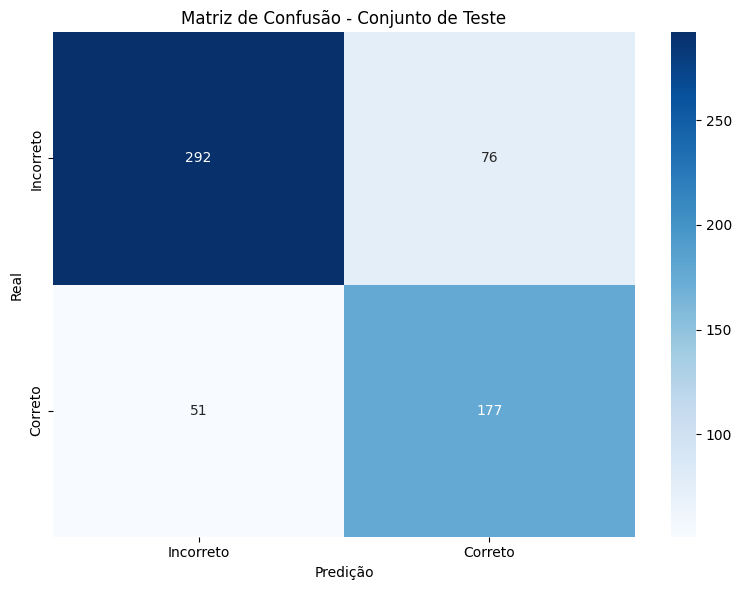

✅ Matriz de confusão salva em: data/output/notebooks/treinamento_sinkt/confusion_matrix.png


In [16]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        questions = batch['questions'].to(device)
        responses = batch['responses'].to(device)
        masks = batch['masks'].to(device)
        
        predictions = model(questions, responses)
        
        targets = responses[:, 1:].float()
        pred_masks = masks[:, 1:]
        
        valid_preds = predictions[pred_masks == 1].cpu().numpy()
        valid_targets = targets[pred_masks == 1].cpu().numpy()
        
        all_preds.extend(valid_preds)
        all_targets.extend(valid_targets)

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
all_preds_binary = (all_preds >= 0.5).astype(int)

cm = confusion_matrix(all_targets, all_preds_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Incorreto', 'Correto'],
            yticklabels=['Incorreto', 'Correto'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Conjunto de Teste')
plt.tight_layout()
plt.savefig('data/output/notebooks/treinamento_sinkt/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Matriz de confusão salva em: data/output/notebooks/treinamento_sinkt/confusion_matrix.png")

## Análise Detalhada de Predições

In [17]:
model.eval()
error_type_predictions = defaultdict(lambda: {'preds': [], 'targets': []})

idx_to_error_type = {v: k for k, v in error_type_to_idx.items()}

with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        questions = batch['questions'].to(device)
        responses = batch['responses'].to(device)
        masks = batch['masks'].to(device)
        
        predictions = model(questions, responses)
        
        targets = responses[:, 1:].float()
        pred_masks = masks[:, 1:]
        
        batch_size = questions.size(0)
        for b in range(batch_size):
            student_idx = batch_idx * config['batch_size'] + b
            if student_idx >= len(test_dataset):
                break
            
            student_data = test_dataset.sequences[student_idx]
            error_types_seq = student_data.get('error_types', [])
            
            for t in range(predictions.size(1)):
                if pred_masks[b, t] == 1:
                    if t + 1 < len(error_types_seq):
                        error_type_idx = error_types_seq[t + 1]
                        error_type = idx_to_error_type.get(error_type_idx, 'unknown')
                        
                        pred_val = predictions[b, t].cpu().item()
                        target_val = targets[b, t].cpu().item()
                        
                        error_type_predictions[error_type]['preds'].append(pred_val)
                        error_type_predictions[error_type]['targets'].append(target_val)

print("Métricas por Tipo de Erro:")
print("=" * 60)

error_metrics = {}
for error_type, data in error_type_predictions.items():
    if len(data['targets']) > 10:
        preds = np.array(data['preds'])
        targets = np.array(data['targets'])
        
        if len(np.unique(targets)) > 1:
            auc = roc_auc_score(targets, preds)
            acc = accuracy_score(targets, (preds >= 0.5).astype(int))
            f1 = f1_score(targets, (preds >= 0.5).astype(int), zero_division=0)
            
            error_metrics[error_type] = {'auc': auc, 'acc': acc, 'f1': f1, 'count': len(targets)}
            
            print(f"\n{error_type}:")
            print(f"  - Amostras: {len(targets)}")
            print(f"  - AUC: {auc:.4f}")
            print(f"  - Accuracy: {acc:.4f}")
            print(f"  - F1-Score: {f1:.4f}")

print("\n" + "=" * 60)

Métricas por Tipo de Erro:



## Análise por Tipo de Erro

In [18]:
if error_metrics:
    error_types_list = list(error_metrics.keys())
    auc_values = [error_metrics[et]['auc'] for et in error_types_list]
    acc_values = [error_metrics[et]['acc'] for et in error_types_list]
    f1_values = [error_metrics[et]['f1'] for et in error_types_list]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    x_pos = np.arange(len(error_types_list))
    
    axes[0].bar(x_pos, auc_values, color='#2ecc71', alpha=0.7)
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(error_types_list, rotation=45, ha='right')
    axes[0].set_ylabel('AUC')
    axes[0].set_title('AUC por Tipo de Erro')
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    axes[1].bar(x_pos, acc_values, color='#3498db', alpha=0.7)
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(error_types_list, rotation=45, ha='right')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy por Tipo de Erro')
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    axes[2].bar(x_pos, f1_values, color='#e74c3c', alpha=0.7)
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(error_types_list, rotation=45, ha='right')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_title('F1-Score por Tipo de Erro')
    axes[2].set_ylim(0, 1)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('data/output/notebooks/treinamento_sinkt/metrics_by_error_type.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Gráficos de métricas por tipo de erro salvos")
else:
    print("Dados insuficientes para análise por tipo de erro")

Dados insuficientes para análise por tipo de erro


## Visualização de Métricas por Tipo de Erro

In [19]:
if error_metrics:
    error_types_list = list(error_metrics.keys())
    auc_values = [error_metrics[et]['auc'] for et in error_types_list]
    acc_values = [error_metrics[et]['acc'] for et in error_types_list]
    f1_values = [error_metrics[et]['f1'] for et in error_types_list]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    x_pos = np.arange(len(error_types_list))
    
    axes[0].bar(x_pos, auc_values, color='#2ecc71', alpha=0.7)
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(error_types_list, rotation=45, ha='right')
    axes[0].set_ylabel('AUC')
    axes[0].set_title('AUC por Tipo de Erro')
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    axes[1].bar(x_pos, acc_values, color='#3498db', alpha=0.7)
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(error_types_list, rotation=45, ha='right')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy por Tipo de Erro')
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    axes[2].bar(x_pos, f1_values, color='#e74c3c', alpha=0.7)
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(error_types_list, rotation=45, ha='right')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_title('F1-Score por Tipo de Erro')
    axes[2].set_ylim(0, 1)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('data/output/notebooks/treinamento_sinkt/metrics_by_error_type.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Gráficos de métricas por tipo de erro salvos")
else:
    print("❌ Dados insuficientes para análise por tipo de erro")

❌ Dados insuficientes para análise por tipo de erro


## Salvamento dos Resultados

In [20]:
os.makedirs('data/output/notebooks/treinamento_sinkt', exist_ok=True)

torch.save({
    'model_state_dict': best_model_state if best_model_state is not None else model.state_dict(),
    'config': config,
    'test_metrics': test_metrics,
    'history': history
}, 'data/output/notebooks/treinamento_sinkt/sinkt_model.pt')

results_summary = {
    'metadata': {
        'created_at': datetime.now().isoformat(),
        'model': 'SINKT',
        'num_epochs_trained': len(history['train_loss']),
        'best_val_auc': best_val_auc,
        'device': str(device)
    },
    'config': config,
    'data_split': {
        'train_students': len(train_ids),
        'val_students': len(val_ids),
        'test_students': len(test_ids),
        'train_sequences': len(train_dataset),
        'val_sequences': len(val_dataset),
        'test_sequences': len(test_dataset)
    },
    'test_metrics': {
        'loss': float(test_metrics['loss']),
        'auc': float(test_metrics['auc']),
        'accuracy': float(test_metrics['acc']),
        'f1_score': float(test_metrics['f1']),
        'precision': float(test_metrics['precision']),
        'recall': float(test_metrics['recall'])
    },
    'training_history': {
        'train_loss': [float(x) for x in history['train_loss']],
        'val_loss': [float(x) for x in history['val_loss']],
        'val_auc': [float(x) for x in history['val_auc']],
        'val_acc': [float(x) for x in history['val_acc']],
        'val_f1': [float(x) for x in history['val_f1']]
    }
}

with open('data/output/notebooks/treinamento_sinkt/training_results.json', 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print("✅ Resultados salvos:")
print("  - Modelo: data/output/notebooks/treinamento_sinkt/sinkt_model.pt")
print("  - Resumo: data/output/notebooks/treinamento_sinkt/training_results.json")

✅ Resultados salvos:
  - Modelo: data/output/notebooks/treinamento_sinkt/sinkt_model.pt
  - Resumo: data/output/notebooks/treinamento_sinkt/training_results.json


## Resumo Final

In [21]:
print("=" * 80)
print("RESUMO DO TREINAMENTO DO MODELO SINKT")
print("=" * 80)
print(f"\nDADOS:")
print(f"  - Conceitos: {len(concepts)}")
print(f"  - Questões: {len(questions)}")
print(f"  - Estudantes (train/val/test): {len(train_ids)}/{len(val_ids)}/{len(test_ids)}")
print(f"  - Interações totais: {len(interactions)}")

print(f"\nARQUITETURA:")
print(f"  - TIEnc: Sentence-BERT ({config['plm_model']})")
print(f"  - SIEnc: GAT com {config['gat_layers']} camadas e {config['gat_heads']} heads")
print(f"  - Student Encoder: GRU com {config['gru_layers']} camadas")
print(f"  - Hidden dim: {config['hidden_dim']}")
print(f"  - Parâmetros treináveis: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

print(f"\nTREINAMENTO:")
print(f"  - Épocas treinadas: {len(history['train_loss'])}")
print(f"  - Melhor AUC (validação): {best_val_auc:.4f}")
print(f"  - Learning rate: {config['learning_rate']}")
print(f"  - Batch size: {config['batch_size']}")

print(f"\nMÉTRICAS FINAIS (TESTE):")
print(f"  - AUC:       {test_metrics['auc']:.4f}")
print(f"  - Accuracy:  {test_metrics['acc']:.4f}")
print(f"  - F1-Score:  {test_metrics['f1']:.4f}")
print(f"  - Precision: {test_metrics['precision']:.4f}")
print(f"  - Recall:    {test_metrics['recall']:.4f}")

print(f"\nARQUIVOS GERADOS:")
print(f"  - data/output/notebooks/treinamento_sinkt/sinkt_model.pt")
print(f"  - data/output/notebooks/treinamento_sinkt/training_results.json")
print(f"  - data/output/notebooks/treinamento_sinkt/training_results.png")
print(f"  - data/output/notebooks/treinamento_sinkt/confusion_matrix.png")

print("\n" + "=" * 80)
print("✅ TREINAMENTO DO SINKT CONCLUÍDO COM SUCESSO!")
print("=" * 80)

RESUMO DO TREINAMENTO DO MODELO SINKT

DADOS:
  - Conceitos: 251
  - Questões: 15
  - Estudantes (train/val/test): 70/15/15
  - Interações totais: 4499

ARQUITETURA:
  - TIEnc: Sentence-BERT (sentence-transformers/all-MiniLM-L6-v2)
  - SIEnc: GAT com 2 camadas e 4 heads
  - Student Encoder: GRU com 2 camadas
  - Hidden dim: 128
  - Parâmetros treináveis: 504,065

TREINAMENTO:
  - Épocas treinadas: 34
  - Melhor AUC (validação): 0.7999
  - Learning rate: 0.001
  - Batch size: 32

MÉTRICAS FINAIS (TESTE):
  - AUC:       0.8218
  - Accuracy:  0.7869
  - F1-Score:  0.7360
  - Precision: 0.6996
  - Recall:    0.7763

ARQUIVOS GERADOS:
  - data/output/notebooks/treinamento_sinkt/sinkt_model.pt
  - data/output/notebooks/treinamento_sinkt/training_results.json
  - data/output/notebooks/treinamento_sinkt/training_results.png
  - data/output/notebooks/treinamento_sinkt/confusion_matrix.png

✅ TREINAMENTO DO SINKT CONCLUÍDO COM SUCESSO!
